# Personalized Cancer Diagnosis (Balanced Dataset & TF-IDF Features)

This notebook demonstrates a full workflow for personalized cancer diagnosis using a balanced dataset and TF-IDF features. All models and analyses are performed using the balanced data and TF-IDF representations.

## 1. Import Required Libraries

Import all necessary libraries for data processing, visualization, balancing, and modeling.

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
from nltk.corpus import stopwords

# Machine learning and feature extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# Utilities
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings("ignore")

## 2. Read and Preprocess Data

Read gene, variation, and text data. Merge on ID and handle missing values.

In [26]:
# Read gene and variation data
data = pd.read_csv(r'training_variants_balanced.csv')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
display(data.head())

# Read text data
data_text = pd.read_csv(
    r'training_text_balanced.csv',
    sep='\t',
  
    names=["ID", "TEXT"],
    skiprows=1
)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
display(data_text.head())

# Merge on ID
result = pd.concat([data, data_text], axis=1)
print("Merged data shape:", result.shape)
display(result.head())

# Handle missing text values
result.loc[result['TEXT'].isnull(), 'TEXT'] = result['Gene'] + ' ' + result['Variation']
print("Missing TEXT values filled.")

Number of data points :  8577
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,1090,KLF4,K409Q,2
1,1555,ALK,R1060H,3
2,2205,PTEN,C136R,4
3,2751,BRAF,N486_P490del,2
4,3293,RET,V804G,1


Number of data points :  8577
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,1090,Abstract Meningiomas are among the most freque...
1,1555,"In the era of personalized medicine, understan..."
2,2205,Germline mutations in PTEN have been described...
3,2751,We have identifi ed previously undiscovered BR...
4,3293,RET is a transmembrane tyrosine kinase partici...


Merged data shape: (8577, 6)


,ID,Gene,Variation,Class,ID,TEXT
0,1090,KLF4,K409Q,2,1090,Abstract Meningiomas are among the most freque...
1,1555,ALK,R1060H,3,1555,"In the era of personalized medicine, understan..."
2,2205,PTEN,C136R,4,2205,Germline mutations in PTEN have been described...
3,2751,BRAF,N486_P490del,2,2751,We have identifi ed previously undiscovered BR...
4,3293,RET,V804G,1,3293,RET is a transmembrane tyrosine kinase partici...


Missing TEXT values filled.


## 3. Balance the Dataset (SMOTE)

Apply SMOTE to balance the training data before feature extraction.

In [31]:
print("Full data class distribution:\n", result['Class'].value_counts())
print("Train class distribution:\n", train_df['Class'].value_counts())
print("CV class distribution:\n", cv_df['Class'].value_counts())
print("Test class distribution:\n", test_df['Class'].value_counts())

Full data class distribution:
 Class
2    953
3    953
4    953
1    953
8    953
5    953
6    953
7    953
9    953
Name: count, dtype: int64
Train class distribution:
 Class
9    610
8    610
4    610
3    610
6    610
2    610
5    610
1    610
7    609
Name: count, dtype: int64
CV class distribution:
 Class
2    153
1    153
7    153
6    153
4    152
9    152
5    152
8    152
3    152
Name: count, dtype: int64
Test class distribution:
 Class
7    191
4    191
8    191
3    191
9    191
5    191
6    190
1    190
2    190
Name: count, dtype: int64


In [32]:
# Prepare for balancing: encode categorical features for SMOTE
from sklearn.preprocessing import LabelEncoder

# We'll balance after splitting into train/test/cv, but first encode labels
result['Class'] = result['Class'].astype(int)
y = result['Class'].values

# Split before balancing to avoid data leakage
X_train, X_temp, y_train, y_temp = train_test_split(result, y, stratify=y, test_size=0.36, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5555, random_state=42) # 0.5555*0.36 ≈ 0.2

print("Train:", X_train.shape, "CV:", X_cv.shape, "Test:", X_test.shape)

# For SMOTE, we need numeric features. We'll use only the text for now, and balance after text preprocessing.
train_df = X_train.copy()
cv_df = X_cv.copy()
test_df = X_test.copy()

Train: (5489, 6) CV: (1372, 6) Test: (1716, 6)


## 4. Text Preprocessing

Clean and preprocess the text data: remove special characters, lowercase, remove stopwords, etc.

In [33]:
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(text):
    if type(text) is not int:
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        text = re.sub('\s+', ' ', text)
        text = text.lower()
        return ' '.join([word for word in text.split() if word not in stop_words])
    else:
        return ""

# Apply preprocessing
for df in [train_df, cv_df, test_df]:
    df['TEXT'] = df['TEXT'].apply(nlp_preprocessing)
print("Text preprocessing completed.")

Text preprocessing completed.


## 5. Feature Engineering with TF-IDF

Extract TF-IDF features for text, gene, and variation fields.

In [7]:
# TF-IDF for TEXT
tfidf_text = TfidfVectorizer(min_df=3, max_features=10000)
train_text_tfidf = tfidf_text.fit_transform(train_df['TEXT'])
cv_text_tfidf = tfidf_text.transform(cv_df['TEXT'])
test_text_tfidf = tfidf_text.transform(test_df['TEXT'])

print("TF-IDF (Text) shapes:", train_text_tfidf.shape, cv_text_tfidf.shape, test_text_tfidf.shape)

# TF-IDF for GENE
tfidf_gene = TfidfVectorizer()
train_gene_tfidf = tfidf_gene.fit_transform(train_df['Gene'])
cv_gene_tfidf = tfidf_gene.transform(cv_df['Gene'])
test_gene_tfidf = tfidf_gene.transform(test_df['Gene'])

print("TF-IDF (Gene) shapes:", train_gene_tfidf.shape, cv_gene_tfidf.shape, test_gene_tfidf.shape)

# TF-IDF for VARIATION
tfidf_var = TfidfVectorizer()
train_var_tfidf = tfidf_var.fit_transform(train_df['Variation'])
cv_var_tfidf = tfidf_var.transform(cv_df['Variation'])
test_var_tfidf = tfidf_var.transform(test_df['Variation'])

print("TF-IDF (Variation) shapes:", train_var_tfidf.shape, cv_var_tfidf.shape, test_var_tfidf.shape)

# Stack all features horizontally
from scipy.sparse import hstack

train_x = hstack([train_gene_tfidf, train_var_tfidf, train_text_tfidf]).tocsr()
cv_x = hstack([cv_gene_tfidf, cv_var_tfidf, cv_text_tfidf]).tocsr()
test_x = hstack([test_gene_tfidf, test_var_tfidf, test_text_tfidf]).tocsr()

print("Final feature shapes:", train_x.shape, cv_x.shape, test_x.shape)

TF-IDF (Text) shapes: (5489, 713) (1372, 713) (1716, 713)
TF-IDF (Gene) shapes: (5489, 228) (1372, 228) (1716, 228)
TF-IDF (Variation) shapes: (5489, 1989) (1372, 1989) (1716, 1989)
Final feature shapes: (5489, 2930) (1372, 2930) (1716, 2930)


In [36]:
import pandas as pd

# Get feature names
feature_names = (
    list(tfidf_gene.get_feature_names_out()) +
    list(tfidf_var.get_feature_names_out()) +
    list(tfidf_text.get_feature_names_out())
)

# Convert to DataFrame (may be large!)
train_x_df = pd.DataFrame(train_x.toarray(), columns=feature_names)

# Save to CSV
train_x_df.to_csv("train_x_tfidf.csv", index=False)

## 6. Balance the Training Set with SMOTE

Apply SMOTE to the training set to balance class distribution.

In [8]:
# SMOTE requires dense input
smote = SMOTE(random_state=42, n_jobs=-1)
train_x_bal, y_train_bal = smote.fit_resample(train_x, train_df['Class'].values)
print("After SMOTE, train shape:", train_x_bal.shape)
print("Class distribution after SMOTE:", Counter(y_train_bal))

After SMOTE, train shape: (5490, 2930)
Class distribution after SMOTE: Counter({9: 610, 7: 610, 8: 610, 4: 610, 3: 610, 6: 610, 2: 610, 5: 610, 1: 610})


## 7. Univariate Analysis (Gene, Variation, Text)

Analyze the distribution of gene, variation, and text features using TF-IDF representation.

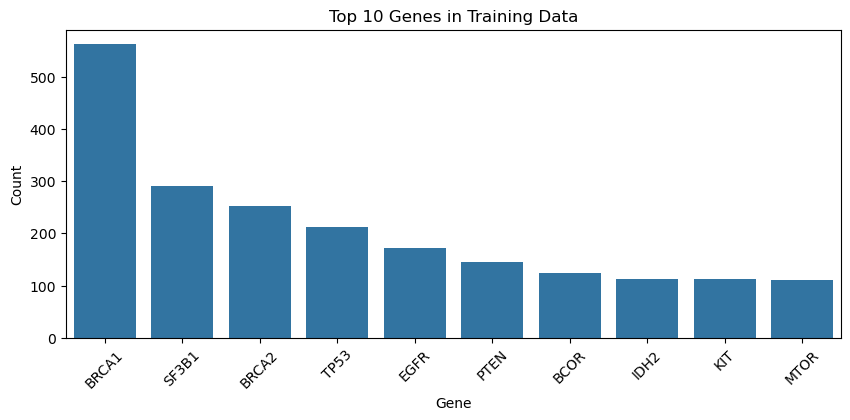

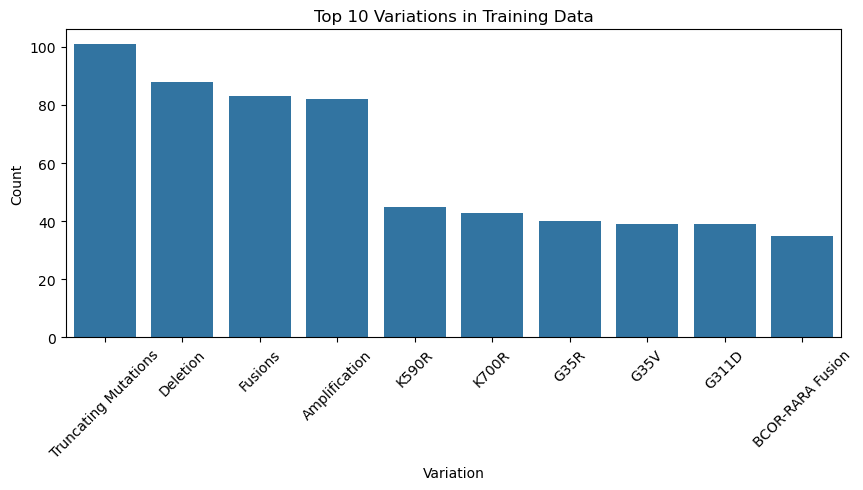

Number of unique words in TF-IDF (Text): 713


In [37]:
# Gene distribution
gene_counts = train_df['Gene'].value_counts()
plt.figure(figsize=(10,4))
sns.barplot(x=gene_counts.index[:10], y=gene_counts.values[:10])
plt.title("Top 10 Genes in Training Data")
plt.ylabel("Count")
plt.xlabel("Gene")
plt.xticks(rotation=45)
plt.show()

# Variation distribution
var_counts = train_df['Variation'].value_counts()
plt.figure(figsize=(10,4))
sns.barplot(x=var_counts.index[:10], y=var_counts.values[:10])
plt.title("Top 10 Variations in Training Data")
plt.ylabel("Count")
plt.xlabel("Variation")
plt.xticks(rotation=45)
plt.show()

# Text: Number of unique words in TF-IDF
print("Number of unique words in TF-IDF (Text):", len(tfidf_text.get_feature_names_out()))

## 8. Model Training and Evaluation with TF-IDF Features

Train and evaluate all models using TF-IDF features and the balanced dataset. Use multiclass log-loss and confusion matrix for evaluation.

=== Multinomial Naive Bayes ===
Naive Bayes Log Loss (Train): 0.46533334081732647
Naive Bayes Log Loss (CV): 0.6512997384084064
Naive Bayes Log Loss (Test): 0.6829078134876024


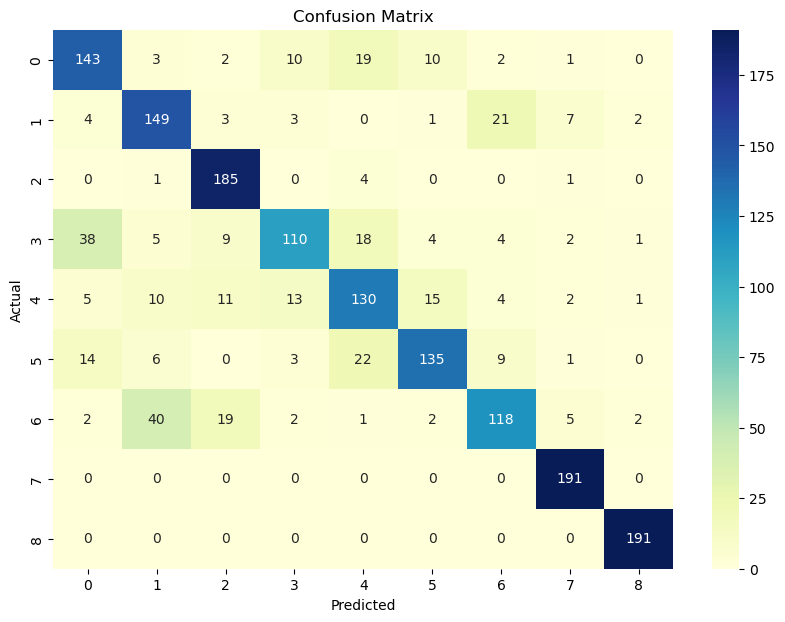

=== K Nearest Neighbors ===
KNN Log Loss (Train): 0.5711427999076867
KNN Log Loss (CV): 0.7054640717700716
KNN Log Loss (Test): 0.7039185922899479


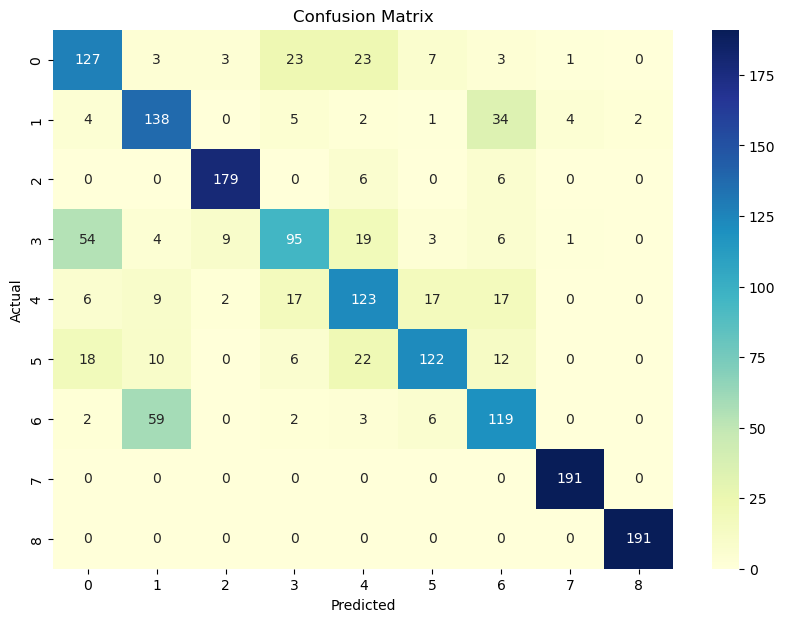

=== Logistic Regression ===
Logistic Regression Log Loss (Train): 0.5270255318125824
Logistic Regression Log Loss (CV): 0.6450003582389565
Logistic Regression Log Loss (Test): 0.67083160642084


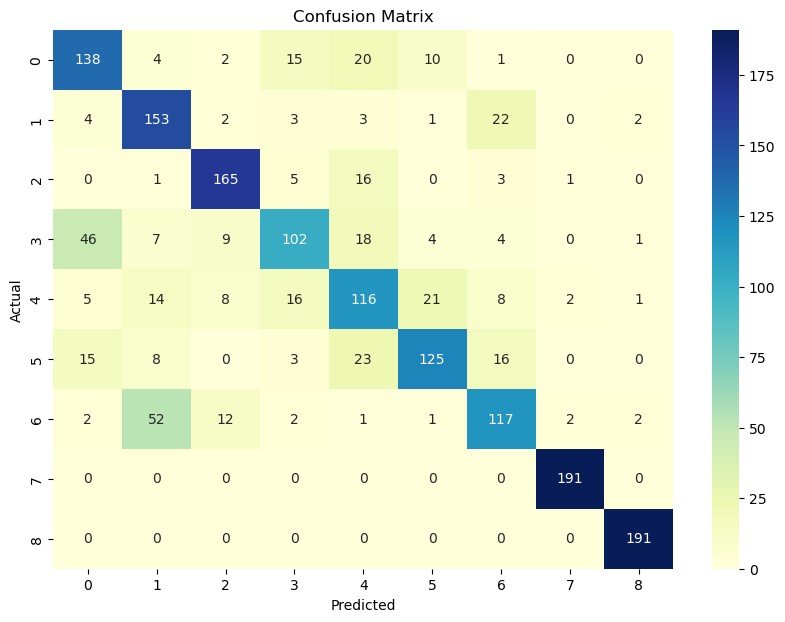

=== Linear SVM ===
Linear SVM Log Loss (Train): 0.33592171446602037
Linear SVM Log Loss (CV): 0.5218939361166031
Linear SVM Log Loss (Test): 0.5193409696731913


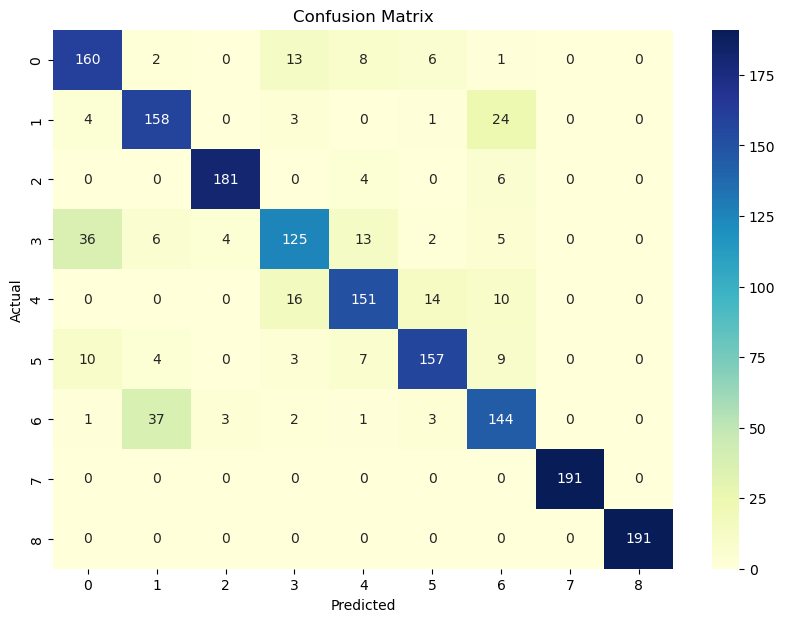

=== Random Forest ===
Random Forest Log Loss (Train): 1.0131070538444518
Random Forest Log Loss (CV): 1.0741333356936622
Random Forest Log Loss (Test): 1.0840073008976507


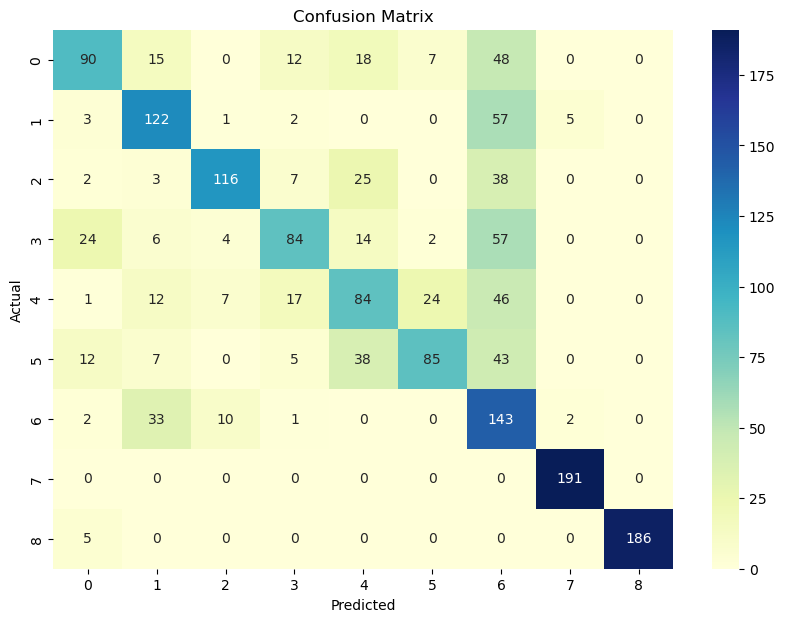

=== Stacking Classifier ===
Stacking Log Loss (CV): 0.4217284868431693
Stacking Log Loss (Test): 0.42762761561524093


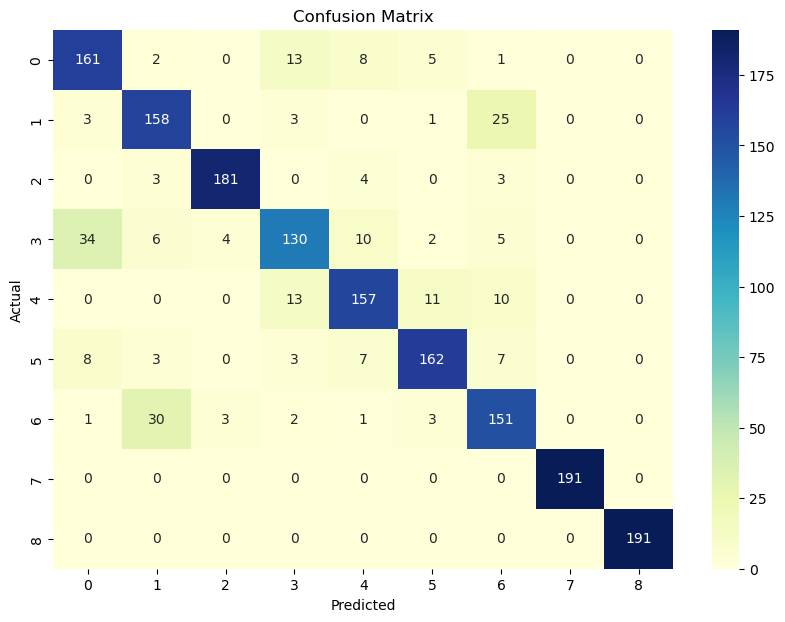

Voting Log Loss (CV): 0.6703017240269425
Voting Log Loss (Test): 0.6780572127488039


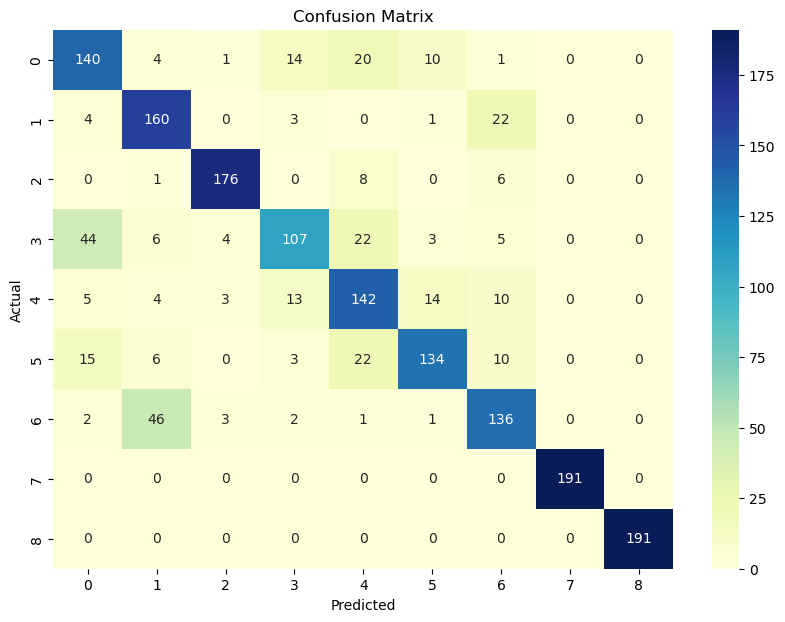

In [38]:
def plot_confusion_matrix(test_y, predict_y, labels=None):
    C = confusion_matrix(test_y, predict_y, labels=labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(C, annot=True, fmt="d", cmap="YlGnBu")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def evaluate_model(clf, train_x, train_y, cv_x, cv_y, test_x, test_y, model_name="Model"):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    print(f"{model_name} Log Loss (Train):", log_loss(train_y, sig_clf.predict_proba(train_x)))
    print(f"{model_name} Log Loss (CV):", log_loss(cv_y, sig_clf.predict_proba(cv_x)))
    print(f"{model_name} Log Loss (Test):", log_loss(test_y, sig_clf.predict_proba(test_x)))
    preds = sig_clf.predict(test_x)
    plot_confusion_matrix(test_y, preds, labels=np.unique(test_y))
    return sig_clf

# Naive Bayes
nb_clf = MultinomialNB()
print("=== Multinomial Naive Bayes ===")
nb_sig_clf = evaluate_model(nb_clf, train_x_bal, y_train_bal, cv_x, cv_df['Class'].values, test_x, test_df['Class'].values, "Naive Bayes")

# KNN
knn_clf = KNeighborsClassifier(n_neighbors=11, n_jobs=-1)
print("=== K Nearest Neighbors ===")
knn_sig_clf = evaluate_model(knn_clf, train_x_bal, y_train_bal, cv_x, cv_df['Class'].values, test_x, test_df['Class'].values, "KNN")

# Logistic Regression
lr_clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, class_weight='balanced', random_state=42)
print("=== Logistic Regression ===")
lr_sig_clf = evaluate_model(lr_clf, train_x_bal, y_train_bal, cv_x, cv_df['Class'].values, test_x, test_df['Class'].values, "Logistic Regression")

# SVM (Linear)
svm_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, class_weight='balanced', random_state=42)
print("=== Linear SVM ===")
svm_sig_clf = evaluate_model(svm_clf, train_x_bal, y_train_bal, cv_x, cv_df['Class'].values, test_x, test_df['Class'].values, "Linear SVM")

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
print("=== Random Forest ===")
rf_sig_clf = evaluate_model(rf_clf, train_x_bal, y_train_bal, cv_x, cv_df['Class'].values, test_x, test_df['Class'].values, "Random Forest")

# Stacking
from mlxtend.classifier import StackingClassifier
meta_lr = LogisticRegression(max_iter=1000)
stack_clf = StackingClassifier(classifiers=[lr_sig_clf, svm_sig_clf, rf_sig_clf], meta_classifier=meta_lr, use_probas=True)
print("=== Stacking Classifier ===")
stack_clf.fit(train_x_bal, y_train_bal)
print("Stacking Log Loss (CV):", log_loss(cv_df['Class'].values, stack_clf.predict_proba(cv_x)))
print("Stacking Log Loss (Test):", log_loss(test_df['Class'].values, stack_clf.predict_proba(test_x)))
plot_confusion_matrix(test_df['Class'].values, stack_clf.predict(test_x), labels=np.unique(test_df['Class'].values))

# Voting
voting_clf = VotingClassifier(estimators=[
    ('lr', lr_sig_clf), ('svm', svm_sig_clf), ('rf', rf_sig_clf)
], voting='soft', n_jobs=-1)
voting_clf.fit(train_x_bal, y_train_bal)
print("Voting Log Loss (CV):", log_loss(cv_df['Class'].values, voting_clf.predict_proba(cv_x)))
print("Voting Log Loss (Test):", log_loss(test_df['Class'].values, voting_clf.predict_proba(test_x)))
plot_confusion_matrix(test_df['Class'].values, voting_clf.predict(test_x), labels=np.unique(test_df['Class'].values))

## 9. Feature Importance Analysis

Analyze and visualize feature importance for each model using TF-IDF features.

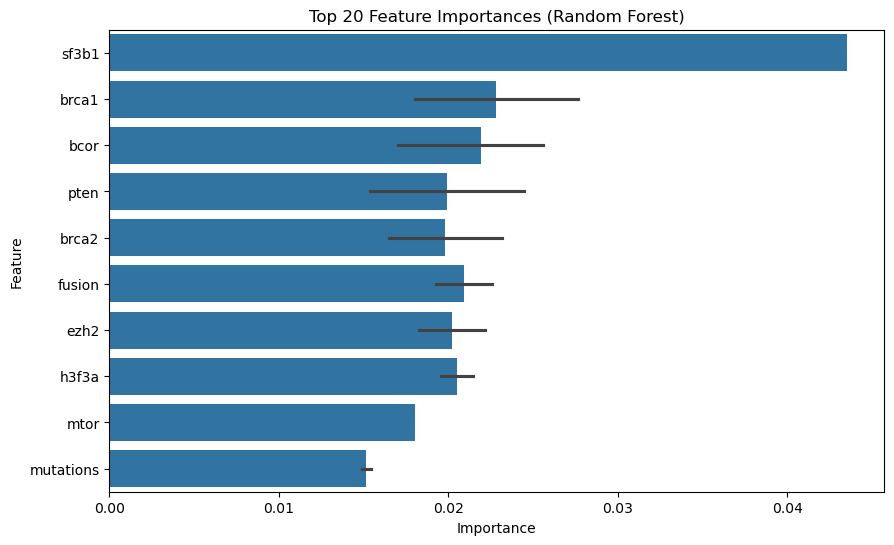

In [39]:
# For Random Forest: Feature importances
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1][:20]
feature_names = (
    list(tfidf_gene.get_feature_names_out()) +
    list(tfidf_var.get_feature_names_out()) +
    list(tfidf_text.get_feature_names_out())
)
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=top_features)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## 10. Assignment Tasks with TF-IDF (Top 1000 words, N-grams, Feature Engineering)

Implement assignment tasks: use only top 1000 TF-IDF words, apply Logistic Regression with unigrams and bigrams, and try additional feature engineering to reduce log-loss.

=== Logistic Regression (Top 1000 TF-IDF words) ===
LogReg-1000 Log Loss (Train): 0.5270255318125824
LogReg-1000 Log Loss (CV): 0.6450003582389565
LogReg-1000 Log Loss (Test): 0.67083160642084


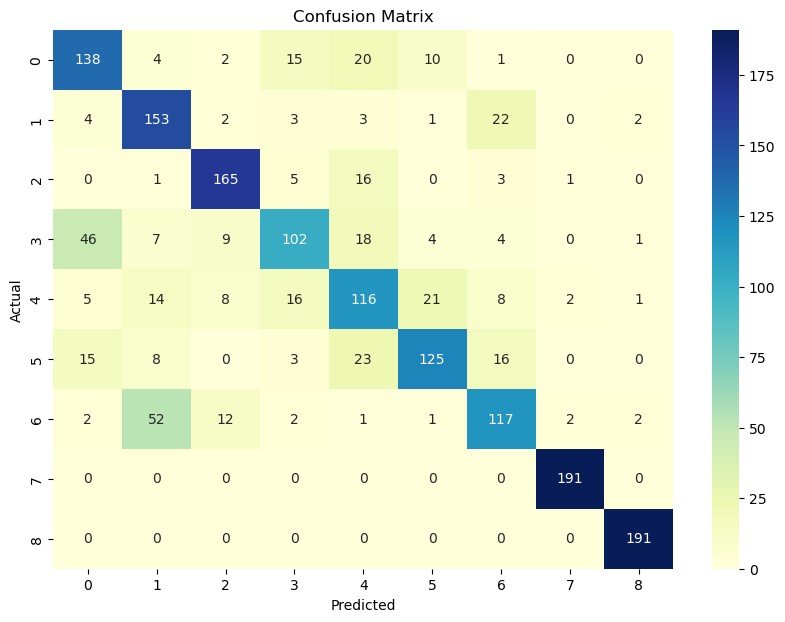

=== Logistic Regression (Unigrams + Bigrams) ===
LogReg-Ngram Log Loss (Train): 0.5047417827965236
LogReg-Ngram Log Loss (CV): 0.6239737347450426
LogReg-Ngram Log Loss (Test): 0.6519427745357574


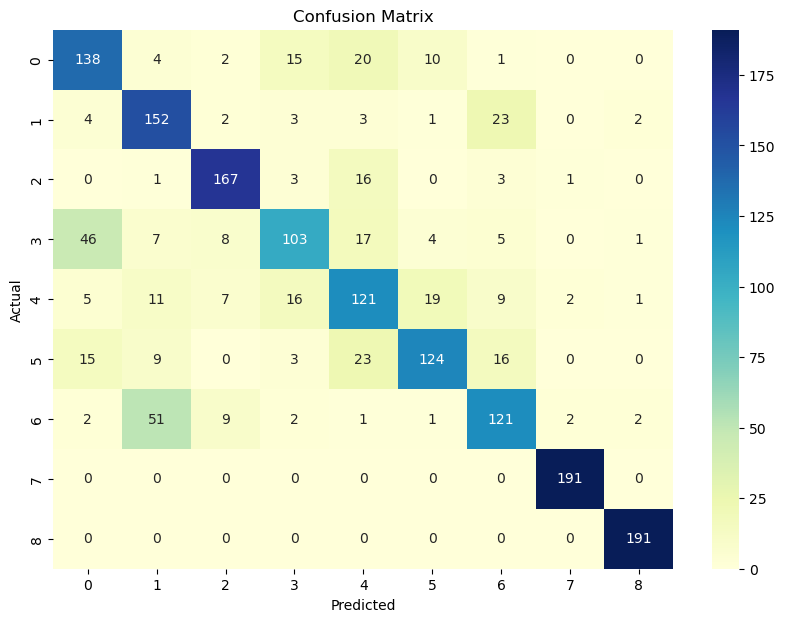

=== Logistic Regression (SVD-reduced TF-IDF) ===
SVD Log Loss (CV): 0.8452554880853399
SVD Log Loss (Test): 0.8461359676771241


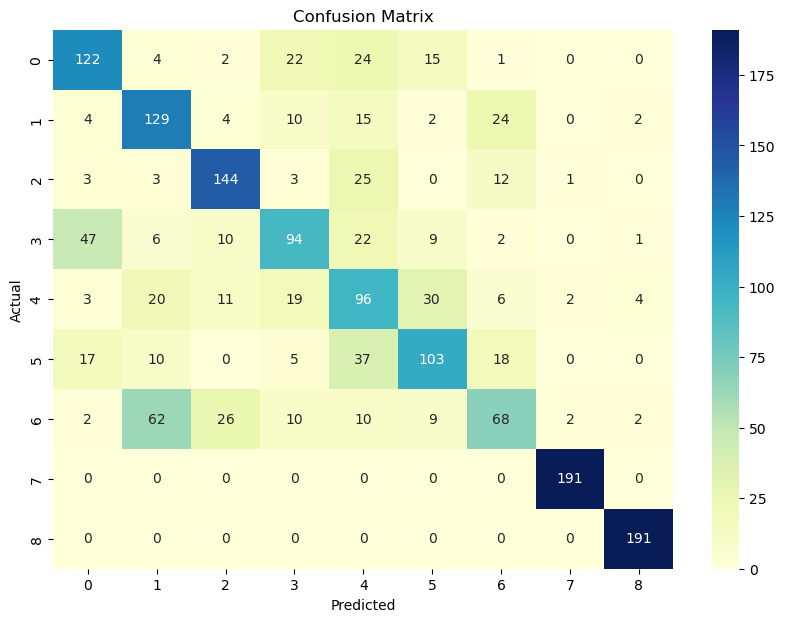

In [15]:
# 1. Use only top 1000 TF-IDF words
tfidf_text_1000 = TfidfVectorizer(min_df=3, max_features=1000)
train_text_tfidf_1000 = tfidf_text_1000.fit_transform(train_df['TEXT'])
cv_text_tfidf_1000 = tfidf_text_1000.transform(cv_df['TEXT'])
test_text_tfidf_1000 = tfidf_text_1000.transform(test_df['TEXT'])

train_x_1000 = hstack([train_gene_tfidf, train_var_tfidf, train_text_tfidf_1000]).tocsr()
cv_x_1000 = hstack([cv_gene_tfidf, cv_var_tfidf, cv_text_tfidf_1000]).tocsr()
test_x_1000 = hstack([test_gene_tfidf, test_var_tfidf, test_text_tfidf_1000]).tocsr()

# Balance again for top 1000 features
train_x_1000_bal, y_train_1000_bal = smote.fit_resample(train_x_1000, train_df['Class'].values)

# Logistic Regression on top 1000 features
lr_clf_1000 = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, class_weight='balanced', random_state=42)
print("=== Logistic Regression (Top 1000 TF-IDF words) ===")
evaluate_model(lr_clf_1000, train_x_1000_bal, y_train_1000_bal, cv_x_1000, cv_df['Class'].values, test_x_1000, test_df['Class'].values, "LogReg-1000")

# 2. Logistic Regression with unigrams and bigrams
tfidf_text_ngram = TfidfVectorizer(min_df=3, ngram_range=(1,2), max_features=10000)
train_text_tfidf_ngram = tfidf_text_ngram.fit_transform(train_df['TEXT'])
cv_text_tfidf_ngram = tfidf_text_ngram.transform(cv_df['TEXT'])
test_text_tfidf_ngram = tfidf_text_ngram.transform(test_df['TEXT'])

train_x_ngram = hstack([train_gene_tfidf, train_var_tfidf, train_text_tfidf_ngram]).tocsr()
cv_x_ngram = hstack([cv_gene_tfidf, cv_var_tfidf, cv_text_tfidf_ngram]).tocsr()
test_x_ngram = hstack([test_gene_tfidf, test_var_tfidf, test_text_tfidf_ngram]).tocsr()

train_x_ngram_bal, y_train_ngram_bal = smote.fit_resample(train_x_ngram, train_df['Class'].values)

lr_clf_ngram = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, class_weight='balanced', random_state=42)
print("=== Logistic Regression (Unigrams + Bigrams) ===")
evaluate_model(lr_clf_ngram, train_x_ngram_bal, y_train_ngram_bal, cv_x_ngram, cv_df['Class'].values, test_x_ngram, test_df['Class'].values, "LogReg-Ngram")

# 3. Additional Feature Engineering: Try SVD for dimensionality reduction
svd = TruncatedSVD(n_components=200, random_state=42)
train_x_svd = svd.fit_transform(train_x_bal)
cv_x_svd = svd.transform(cv_x)
test_x_svd = svd.transform(test_x)

lr_clf_svd = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
print("=== Logistic Regression (SVD-reduced TF-IDF) ===")
lr_clf_svd.fit(train_x_svd, y_train_bal)
print("SVD Log Loss (CV):", log_loss(cv_df['Class'].values, lr_clf_svd.predict_proba(cv_x_svd)))
print("SVD Log Loss (Test):", log_loss(test_df['Class'].values, lr_clf_svd.predict_proba(test_x_svd)))
plot_confusion_matrix(test_df['Class'].values, lr_clf_svd.predict(test_x_svd), labels=np.unique(test_df['Class'].values))